Instructions:

- Run build_example_data.ipynb, which will populate rental_car_time_series.csv in the example_use directory
- Run this notebook

Notes:
- This notebook is designed to be run locally, and as such, cannot utilize the parallel pipeline. 
  - Sample code to run the parallel pipeline has been inserted and commented out. 
  - In order to use the parallel pipeline, TEMPO requires PySpark and the ability to write to databricks tables

# Setup

## Imports

In [26]:
import pandas as pd
import numpy as np

from tempo_forecasting.utils.training_utils import calculate_time_periods

from tempo_forecasting.utils.logging_utils import logger
from tempo_forecasting.pipeline.preprocessing_pipeline import preprocess_pipeline
from tempo_forecasting.pipeline.training_pipeline import train_pipeline
from tempo_forecasting.pipeline.evaluation_pipeline import evaluation_pipeline

from tempo_forecasting.utils.plotting_utils import plot_side_by_side
from tempo_forecasting.optuna_opt.run_optuna import OptunaConfig

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [27]:
np.random.seed(42)

pd.set_option('display.max_colwidth', None)

## Data Read

In [28]:
demand_df = pd.read_csv("./rental_car_time_series.csv")
demand_df.head(5)

,date,category,n_rented
0,2020-01-01,Car A,56
1,2020-01-01,Car B,85
2,2020-01-01,Car C,31
3,2020-01-01,Car D,957
4,2020-01-01,Car E,14


In [29]:
min_date = demand_df["date"].min()
max_date = pd.Timestamp(demand_df["date"].max())
print(min_date,max_date)

2020-01-01 2024-12-31 00:00:00


## Arg Assignment

In [30]:
date_config = {
    "max_date": str(max_date)[:10],
    "n_test_months": 6,
    "n_train_months": 36,
    "n_validation_sets": 4,
    "cv_window_step_days": 90
}

time_periods = calculate_time_periods(max_date_str = str(date_config['max_date']),
                                      n_test_months = date_config["n_test_months"],
                                      n_train_months = date_config["n_train_months"],
                                      n_validation_sets = date_config["n_validation_sets"],
                                      cv_window_step_days = date_config["cv_window_step_days"],
                                      verbose = True)

full_range
	 {'total_min': '2020-10-04', 'last_cv_min': '2021-07-01', 'last_cv_cutoff': '2024-06-30', 'total_max': '2024-12-31'}
cv_windows
	 {'min': '2020-10-04', 'cutoff': '2023-10-04', 'max': '2024-04-05'}
	 {'min': '2021-01-02', 'cutoff': '2024-01-02', 'max': '2024-07-04'}
	 {'min': '2021-04-02', 'cutoff': '2024-04-01', 'max': '2024-10-02'}
	 {'min': '2021-07-01', 'cutoff': '2024-06-30', 'max': '2024-12-31'}
retrain_range
	 {'min': '2020-10-04', 'max': '2024-12-31'}


In [31]:
args = {
    'date_col': 'date',
    'target_y': 'n_rented',
    'freq': 'D',
    'cv_dates': [[d["min"],d["cutoff"],d["max"]] for d in time_periods["cv_windows"]],
    'retrain_dates': [time_periods["retrain_range"]["min"],time_periods["retrain_range"]["max"]],
    'use_parallel': False
    }

logger.info(f"Initializing model args: {args}")

n_trials = 3
optuna_config = OptunaConfig(
    n_trials = n_trials,
    n_startup_trials = 10,
    timeout_sec = 30 * n_trials * date_config["n_validation_sets"], # allocate 10 seconds per trial as program timeout
    eval_metric = "wmape"
)

group_col = 'category'

2025-07-16 13:59:16,444 - INFO - Initializing model args: {'date_col': 'date', 'target_y': 'n_rented', 'freq': 'D', 'cv_dates': [['2020-10-04', '2023-10-04', '2024-04-05'], ['2021-01-02', '2024-01-02', '2024-07-04'], ['2021-04-02', '2024-04-01', '2024-10-02'], ['2021-07-01', '2024-06-30', '2024-12-31']], 'retrain_dates': ['2020-10-04', '2024-12-31'], 'use_parallel': False}


## Helper Functions

In [32]:
def plot_init_model_charts(category,all_date_vals,param_df):
    tmp_params = param_df[param_df["category"]==category]

    best_metric_type = tmp_params["metric_type"][0]
    best_metric_avg_val = round(tmp_params["cv_avg_metric"][0],4)

    p = tmp_params["best_params"][0]

    line_limit = 150
    if len(p)>line_limit:
        chunked_p = []
        current_line = ""
        for s in p.split(","):
            if len(current_line) + len(s) <= line_limit:
                current_line += f"{s}, "
            else:
                chunked_p.append(f"{current_line}")
                current_line = s
        chunked_p.append(current_line)

        p = "\n".join(chunked_p)

    cap_add = f"; Cross-Validation Avg. {best_metric_type} = {best_metric_avg_val}\n{p}"

    plot_side_by_side(category,all_date_vals,param_df,caption_add=cap_add)

In [33]:
def get_base_colors():
    # Create a color palette with enough colors for all model types
    # Using a mix of qualitative colors that work well for both regular and vivid versions
    base_colors = [
        '#1f77b4',  # Blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd',  # Purple
        '#8c564b',  # Brown
        '#e377c2',  # Pink
        '#7f7f7f',  # Gray
        '#bcbd22',  # Olive
        '#17becf',  # Cyan
        '#aec7e8',  # Light blue
        '#ffbb78',  # Light orange
        '#98df8a',  # Light green
        '#ff9896',  # Light red
        '#c5b0d5',  # Light purple
    ]

    return base_colors

def plot_model_performance(df, 
                           figsize=(8, 6), 
                           alpha_regular=0.4, 
                           alpha_best=0.9, 
                           marker_size_regular=80, 
                           marker_size_best=50,
                           logscale=False,
                           title="Model Performance: MAE vs WMAPE"):
    """
    Create a scatter plot of model performance metrics (MAE vs WMAPE).
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['category', 'model_type', 'WMAPE', 'MAE', 'is_best_model']
    figsize (tuple): Figure size as (width, height)
    alpha_regular (float): Transparency for regular models (0-1)
    alpha_best (float): Transparency for best models (0-1)
    marker_size_regular (int): Size of regular model markers
    marker_size_best (int): Size of best model markers
    logscale (bool): whether to apply a logarithmic scale to the axes
    title (str): Plot title
    
    Returns:
    fig, ax: Matplotlib figure and axis objects
    """
    
    # Validate input DataFrame
    required_columns = ['category', 'model_type', 'WMAPE', 'MAE', 'is_best_model']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    if df.empty:
        raise ValueError("DataFrame cannot be empty")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique model types
    model_types = df['model_type'].unique()
    
    # Extend colors if we have more model types than base colors
    base_colors = get_base_colors()
    colors = base_colors * (len(model_types) // len(base_colors) + 1)
    
    # Create color mapping for model types
    model_colors = {model_type: colors[i] for i, model_type in enumerate(model_types)}
    
    # Separate data into best models and regular models
    best_models = df[df['is_best_model'] == True]
    regular_models = df[df['is_best_model'] == False]
    
    # Plot regular models first (so best models appear on top)
    for model_type in model_types:
        regular_subset = regular_models[regular_models['model_type'] == model_type]
        if not regular_subset.empty:
            ax.scatter(regular_subset['WMAPE'], regular_subset['MAE'], 
                      color=model_colors[model_type], alpha=alpha_regular, 
                      s=marker_size_regular, label=f'{model_type} (regular)',
                      edgecolors= None, linewidth=0.5)
    
    # Plot best models with vivid colors
    for model_type in model_types:
        best_subset = best_models[best_models['model_type'] == model_type]
        if not best_subset.empty:
            ax.scatter(best_subset['WMAPE'], best_subset['MAE'], 
                      color=model_colors[model_type], alpha=alpha_best, 
                      s=marker_size_best, label=f'{model_type} (best)',
                      edgecolors=None, linewidth=1.5, marker='D')  # Diamond shape for best
    
    # Customize the plot
    ax.set_xlabel('WMAPE (Weighted Mean Absolute Percentage Error)', fontsize=12)
    ax.set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    if logscale:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    
    # Add legend
    # Create a cleaner legend by grouping model types
    handles, labels = ax.get_legend_handles_labels()
    
    # Create custom legend with better organization
    legend_elements = []
    for model_type in model_types:
        # Add entry for regular models
        if any(f'{model_type} (regular)' in label for label in labels):
            legend_elements.append(plt.scatter([], [], color=model_colors[model_type], 
                                             s=marker_size_regular, alpha=alpha_regular, 
                                             edgecolors= None, linewidth=0.5,
                                             label=f'{model_type}'))
        # Add entry for best models
        if any(f'{model_type} (best)' in label for label in labels):
            legend_elements.append(plt.scatter([], [], color=model_colors[model_type], 
                                             s=marker_size_best, alpha=alpha_best, 
                                             edgecolors= None, linewidth=1.5, marker='D',
                                             label=f'{model_type} (best)'))
    
    # Place legend outside the plot area
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Add some styling improvements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    
    # Add text annotation with summary statistics
    total_models = len(df)
    best_models_count = len(best_models)
    unique_categories = df['category'].nunique()
    
    stats_text = f'Total Models: {total_models}\nCategories: {unique_categories}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return fig, ax

# Modeling 

In [34]:
if args['use_parallel']:
    print("Parallel only supported in DataBricks via PySpark currently, sorry.")
    # run_timestamp = datetime.datetime.now(pytz.timezone('America/Chicago')).strftime("%Y%m%d-%H%M%S")
    # print(f"JOB RUN_DATETIME: {run_timestamp}")

    # group_sublist = [] #if you want to select a subset of categories to model

    # demand_df = modeling_df.where(F.col("category_group").isin(group_sublist))

    # parallel_pipeline = ParallelPipeline(run_id = run_timestamp,
    #                                     group_col = "Category_Group",
    #                                     args = args,
    #                                     optuna_config = optuna_config,
    #                                     target_metric = "WMAPE",
    #                                     catalog_name=f"{env}ramp"
    #                                     )

    # modeling_results = parallel_pipeline.run_parallel_forecasting(demand_df)

    # model_parameters_df, model_data_df, full_results_df = parallel_pipeline.postprocess_results(modeling_results)

else:
    results = {}
    param_dfs = []
    output_data_dfs = []

    categories = demand_df[group_col].unique()

    for category in categories:
        # Filter the DataFrame for the current category
        category_data = demand_df[demand_df[group_col]==category].drop(group_col, axis=1).copy()

        # Step 1: Preprocessing
        preproc_output = preprocess_pipeline(category = category,
                                                category_data = category_data, 
                                                args = args,
                                                logger = None)
        model_set, cv_dates, _ = preproc_output
        
        # Step 2: Training
        train_output = train_pipeline(category = category, 
                                        models = model_set, 
                                        modeling_data = category_data, 
                                        args = args, 
                                        optuna_config = optuna_config,
                                        override_cv_dates = cv_dates,
                                        logger = "print")   
        
        category_results, _ = train_output
        results[category] = category_results

        # # Step 3: Evaluation
        eval_output = evaluation_pipeline(category = category,
                                            category_results = category_results,
                                            args = args,
                                            target_metric = "WMAPE",
                                            forecast_horizon = 365,
                                            logger = "print")
        category_param_df, category_output_data_df, _ = eval_output

        param_dfs += [category_param_df]
        output_data_dfs += [category_output_data_df]

        # Build results json, slightly more complicated but same idea
        results_cols = ["category","model","cv_best_avg_metrics",
                        "cv_best_all_metrics","cv_all_trials_all_metrics","best_params"]
        results_df = pd.DataFrame(columns=results_cols)

        for cat in results:
            for model in results[cat]["models"]:
                cm_results = results[cat]["models"][model]

                new_row = {'category': cat, 
                            'model': model,
                            'cv_best_avg_metrics': cm_results["cv_metrics"]["cv_best_mean_all_metrics"],
                            'cv_best_all_metrics': cm_results["cv_metrics"]["cv_best_full_all_metrics"],
                            'cv_all_trials_all_metrics': cm_results["cv_metrics"]["cv_all_trials_all_metrics"],
                            'best_params': cm_results["model_params"],
                            }

                results_df = pd.concat([results_df,pd.DataFrame([new_row])],ignore_index=True)

        param_df = pd.concat(param_dfs)
        output_data_df = pd.concat(output_data_dfs)

2025-07-16 13:59:16,483 - INFO - Category Car A has data in train and test.
2025-07-16 13:59:16,484 - INFO - Category Car A using models: dict_keys(['knn', 'expsmooth', 'prophet', 'xgboost', 'lightgbm'])
2025-07-16 13:59:16,500 - INFO - Category Car A revised cv dates: None


Starting hyperparameter optimization for knn
Initialized OptunaObjective for model: knn
Creating Optuna study: Car A - knn model
Starting optimization for Car A - knn model
Starting trial 0 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
No matching trial found for hash -5978404524018544267.
trial cv metrics: {'RMSE': [41.95, 19.84, 20.92, 14.11], 'MAE': [38.76, 16.7, 18.89, 11.44], 'WMAPE': [27.19, 10.78, 10.75, 6.65]}
Trial 0 completed. Aggregated (mean + std) CV Metric (wmape): 21.729677489444498. Elapsed Time: (0.06s).
Starting trial 1 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Found repeated trial with hash -5978404524018544267. Value: 21.729677489444498
Using cached metric for trial: 21.729677489444498
Starting trial 2 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 90, 'k': 3}
No matching trial found for hash 5833748456755911938.
trial cv metrics: {'RMSE': [43.13, 15.44, 19.33

2025-07-16 14:00:20,222 - INFO - Category Car B has data in train and test.
2025-07-16 14:00:20,223 - INFO - Category Car B using models: dict_keys(['knn', 'expsmooth', 'prophet', 'xgboost', 'lightgbm'])
2025-07-16 14:00:20,239 - INFO - Category Car B revised cv dates: None


Successfully retrained model on full dataset
Last date in training data: 2024-12-31
Predicting 365 days ahead
Successfully generated 365 future predictions
Preparing output DataFrames
Evaluation complete for Car A
Summary: prophet model with train WMAPE=2.8600, forecast horizon=365 days
Starting hyperparameter optimization for knn
Initialized OptunaObjective for model: knn
Creating Optuna study: Car B - knn model
Starting optimization for Car B - knn model
Starting trial 0 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
No matching trial found for hash -5978404524018544267.
trial cv metrics: {'RMSE': [13.35, 5.83, 3.88, 1.87], 'MAE': [12.01, 5.1, 3.04, 1.58], 'WMAPE': [13.13, 5.6, 3.29, 1.76]}
Trial 0 completed. Aggregated (mean + std) CV Metric (wmape): 10.312679589896678. Elapsed Time: (0.06s).
Starting trial 1 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Found repeated trial with hash -5978404524018544267. 

2025-07-16 14:01:20,920 - INFO - Category Car C has data in train and test.
2025-07-16 14:01:20,923 - INFO - Category Car C using models: dict_keys(['knn', 'expsmooth', 'prophet', 'xgboost', 'lightgbm'])
2025-07-16 14:01:20,945 - INFO - Category Car C revised cv dates: None


Successfully retrained model on full dataset
Last date in training data: 2024-12-31
Predicting 365 days ahead
Successfully generated 365 future predictions
Preparing output DataFrames
Evaluation complete for Car B
Summary: prophet model with train WMAPE=1.2300, forecast horizon=365 days
Starting hyperparameter optimization for knn
Initialized OptunaObjective for model: knn
Creating Optuna study: Car C - knn model
Starting optimization for Car C - knn model
Starting trial 0 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
No matching trial found for hash -5978404524018544267.
trial cv metrics: {'RMSE': [2.2, 1.84, 1.12, 3.68], 'MAE': [1.67, 1.45, 0.95, 3.42], 'WMAPE': [5.81, 4.86, 3.06, 11.34]}
Trial 0 completed. Aggregated (mean + std) CV Metric (wmape): 9.35815830366283. Elapsed Time: (0.05s).
Starting trial 1 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Found repeated trial with hash -5978404524018544267. Val

2025-07-16 14:02:22,515 - INFO - Category Car D has data in train and test.
2025-07-16 14:02:22,516 - INFO - Category Car D using models: dict_keys(['knn', 'expsmooth', 'prophet', 'xgboost', 'lightgbm'])
2025-07-16 14:02:22,571 - INFO - Category Car D revised cv dates: None


Successfully generated 365 future predictions
Preparing output DataFrames
Evaluation complete for Car C
Summary: xgboost model with train WMAPE=0.0000, forecast horizon=365 days
Starting hyperparameter optimization for knn
Initialized OptunaObjective for model: knn
Creating Optuna study: Car D - knn model
Starting optimization for Car D - knn model
Starting trial 0 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
No matching trial found for hash -5978404524018544267.
trial cv metrics: {'RMSE': [353.6, 94.08, 302.62, 172.16], 'MAE': [321.8, 84.53, 276.33, 170.24], 'WMAPE': [30.67, 6.99, 20.44, 14.2]}
Trial 0 completed. Aggregated (mean + std) CV Metric (wmape): 26.76580117135354. Elapsed Time: (0.06s).
Starting trial 1 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Found repeated trial with hash -5978404524018544267. Value: 26.76580117135354
Using cached metric for trial: 26.76580117135354
Starting trial 2 for mod

2025-07-16 14:03:27,542 - INFO - Category Car E has data in train and test.
2025-07-16 14:03:27,543 - INFO - Category Car E using models: dict_keys(['knn', 'expsmooth', 'prophet', 'xgboost', 'lightgbm'])
2025-07-16 14:03:27,561 - INFO - Category Car E revised cv dates: None


Successfully generated 365 future predictions
Preparing output DataFrames
Evaluation complete for Car D
Summary: xgboost model with train WMAPE=0.0000, forecast horizon=365 days
Starting hyperparameter optimization for knn
Initialized OptunaObjective for model: knn
Creating Optuna study: Car E - knn model
Starting optimization for Car E - knn model
Starting trial 0 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
No matching trial found for hash -5978404524018544267.
trial cv metrics: {'RMSE': [1.76, 1.26, 1.66, 0.97], 'MAE': [1.67, 1.18, 1.48, 0.87], 'WMAPE': [11.68, 8.05, 9.71, 5.73]}
Trial 0 completed. Aggregated (mean + std) CV Metric (wmape): 10.978230713056849. Elapsed Time: (0.07s).
Starting trial 1 for model knn...
Trial parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Found repeated trial with hash -5978404524018544267. Value: 10.978230713056849
Using cached metric for trial: 10.978230713056849
Starting trial 2 for model knn...


# Standard Assessment

## Output Check

In [35]:
# Details of the final model chosen by Optuna
param_df

,category,model_name,best_params,metric_type,cv_avg_metric,cv_all_metrics,eval_train_metric,eval_test_metric,final_train_metric
0,Car A,prophet,"{'automanual_changepoints': False, 'changepoint_prior_scale': 0.001136467270001117, 'seasonality_prior_scale': 8.123245085588687, 'seasonality_mode': 'additive', 'weekly_seasonality': False}",WMAPE,3.7525,"[3.9, 3.92, 3.22, 3.97]",2.48,3.94,2.86
0,Car B,prophet,"{'automanual_changepoints': False, 'changepoint_prior_scale': 0.014648955132800727, 'seasonality_prior_scale': 0.07476312062252301, 'seasonality_mode': 'additive', 'weekly_seasonality': False}",WMAPE,3.1000,"[2.55, 3.61, 3.83, 2.41]",1.26,2.48,1.23
0,Car C,xgboost,"{'max_depth': 4, 'learning_rate': 0.05958389350068958, 'n_estimators': 400, 'min_child_weight': 3, 'windows': '[7, 30, 92, 184, 365]', 'lags': '[]'}",WMAPE,2.0725,"[1.25, 2.49, 2.76, 1.79]",0.00,1.93,0.00
0,Car D,xgboost,"{'max_depth': 4, 'learning_rate': 0.05958389350068958, 'n_estimators': 400, 'min_child_weight': 3, 'windows': '[7, 30, 92, 184, 365]', 'lags': '[]'}",WMAPE,0.1850,"[0.19, 0.15, 0.16, 0.24]",0.00,0.23,0.00
0,Car E,expsmooth,"{'seasonal_periods': 365, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.51}",WMAPE,3.7025,"[6.06, 2.57, 2.7, 3.48]",0.76,3.20,0.88


In [36]:
# In-depth details for all models run by optuna for each category. 
results_df

,category,model,cv_best_avg_metrics,cv_best_all_metrics,cv_all_trials_all_metrics,best_params
0,Car A,knn,"{'RMSE': 24.205000000000002, 'MAE': 21.447499999999998, 'WMAPE': 13.8425}","{'RMSE': [41.95, 19.84, 20.92, 14.11], 'MAE': [38.76, 16.7, 18.89, 11.44], 'WMAPE': [27.19, 10.78, 10.75, 6.65]}","{'RMSE': [[41.95, 19.84, 20.92, 14.11], [43.13, 15.44, 19.33, 18.01]], 'MAE': [[38.76, 16.7, 18.89, 11.44], [39.6, 12.96, 17.59, 13.38]], 'WMAPE': [[27.19, 10.78, 10.75, 6.65], [27.79, 8.37, 10.01, 7.78]]}","{'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}"
1,Car A,expsmooth,"{'RMSE': 9.4275, 'MAE': 7.9125, 'WMAPE': 4.7925}","{'RMSE': [5.36, 7.08, 11.42, 13.85], 'MAE': [4.2, 6.07, 9.45, 11.93], 'WMAPE': [2.94, 3.92, 5.37, 6.94]}","{'RMSE': [[5.36, 7.08, 11.42, 13.85], [13.01, 19.42, 23.66, 14.34], [5.39, 7.72, 14.81, 10.28]], 'MAE': [[4.2, 6.07, 9.45, 11.93], [11.32, 16.85, 21.69, 12.31], [4.47, 6.71, 12.69, 8.22]], 'WMAPE': [[2.94, 3.92, 5.37, 6.94], [7.94, 10.87, 12.34, 7.16], [3.13, 4.33, 7.22, 4.78]]}","{'seasonal_periods': 365, 'smoothing_level': 0.8, 'smoothing_seasonal': 0.31000000000000005}"
2,Car A,prophet,"{'RMSE': 7.1225000000000005, 'MAE': 6.025, 'WMAPE': 3.7525000000000004}","{'RMSE': [6.65, 7.19, 6.75, 7.9], 'MAE': [5.55, 6.07, 5.66, 6.82], 'WMAPE': [3.9, 3.92, 3.22, 3.97]}","{'RMSE': [[9.04, 9.93, 12.46, 7.9], [6.65, 7.19, 6.75, 7.9], [8.79, 7.34, 12.95, 9.27]], 'MAE': [[7.78, 8.55, 11.05, 6.76], [5.55, 6.07, 5.66, 6.82], [7.44, 6.19, 11.24, 7.73]], 'WMAPE': [[5.46, 5.52, 6.29, 3.93], [3.9, 3.92, 3.22, 3.97], [5.22, 4.0, 6.4, 4.5]]}","{'automanual_changepoints': False, 'changepoint_prior_scale': 0.001136467270001117, 'seasonality_prior_scale': 8.123245085588687, 'seasonality_mode': 'additive', 'weekly_seasonality': False}"
3,Car A,xgboost,"{'RMSE': 14.932500000000001, 'MAE': 13.07, 'WMAPE': 7.9825}","{'RMSE': [9.83, 14.36, 21.2, 14.34], 'MAE': [8.14, 12.38, 19.58, 12.18], 'WMAPE': [5.71, 7.99, 11.14, 7.09]}","{'RMSE': [[7.98, 22.24, 20.71, 14.14], [8.85, 23.8, 22.21, 14.82], [9.83, 14.36, 21.2, 14.34]], 'MAE': [[6.34, 18.25, 18.15, 12.17], [7.35, 19.19, 19.21, 12.46], [8.14, 12.38, 19.58, 12.18]], 'WMAPE': [[4.45, 11.78, 10.33, 7.07], [5.16, 12.39, 10.93, 7.25], [5.71, 7.99, 11.14, 7.09]]}","{'max_depth': 4, 'learning_rate': 0.05958389350068958, 'n_estimators': 400, 'min_child_weight': 3, 'windows': '[7, 30, 92, 184, 365]', 'lags': '[]'}"
4,Car A,lightgbm,"{'RMSE': 13.704999999999998, 'MAE': 11.330000000000002, 'WMAPE': 6.8825}","{'RMSE': [8.45, 11.61, 20.1, 14.66], 'MAE': [6.87, 8.81, 17.16, 12.48], 'WMAPE': [4.82, 5.69, 9.76, 7.26]}","{'RMSE': [[8.45, 11.61, 20.1, 14.66], [8.37, 19.05, 21.91, 15.24], [6.45, 10.92, 20.33, 13.71]], 'MAE': [[6.87, 8.81, 17.16, 12.48], [6.23, 14.58, 18.78, 12.67], [5.33, 8.4, 17.57, 11.7]], 'WMAPE': [[4.82, 5.69, 9.76, 7.26], [4.37, 9.41, 10.68, 7.37], [3.74, 5.42, 9.99, 6.8]]}","{'max_depth': 5, 'learning_rate': 0.08927180304353628, 'n_estimators': 600, 'min_data_in_leaf': 100, 'lambda_l2': 0.02938027938703535, 'windows': '[7, 30, 92, 184, 365]', 'lags': '[184, 365]'}"
5,Car B,knn,"{'RMSE': 6.2325, 'MAE': 5.432499999999999, 'WMAPE': 5.945}","{'RMSE': [13.35, 5.83, 3.88, 1.87], 'MAE': [12.01, 5.1, 3.04, 1.58], 'WMAPE': [13.13, 5.6, 3.29, 1.76]}","{'RMSE': [[13.35, 5.83, 3.88, 1.87], [13.73, 6.59, 2.78, 2.04]], 'MAE': [[12.01, 5.1, 3.04, 1.58], [12.36, 5.42, 2.38, 1.73]], 'WMAPE': [[13.13, 5.6, 3.29, 1.76], [13.52, 5.94, 2.57, 1.92]]}","{'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}"
6,Car B,expsmooth,"{'RMSE': 3.9299999999999997, 'MAE': 3.4025, 'WMAPE': 3.7349999999999994}","{'RMSE': [7.14, 1.61, 2.79, 4.18], 'MAE': [6.49, 1.3, 2.28, 3.54], 'WMAPE': [7.1, 1.43, 2.46, 3.95]}","{'RMSE': [[7.79, 1.67, 4.46, 3.26], [11.57, 5.08, 4.87, 7.75], [7.14, 1.61, 2.79, 4.18]], 'MAE': [[7.05, 1.38, 3.98, 2.68], [10.58, 3.89, 4.1, 7.19], [6.49, 1.3, 2.28, 3.54]], 'WMAPE': [[7.71, 1.52, 4.3, 2.98], [11.58, 4.27, 4.43, 8.02], [7.1, 1.43, 2.46, 3.95]]}","{'seasonal_periods': 365, 'smoothing_level': 0.1

In [37]:
# Final time series values. Contains the true values, the fit and pred values associated with the last cv window, and the fit and forecast values associated with the final retrained model
output_data_df

,date,category,true_vals,eval_train_preds,eval_test_preds,final_train_preds,forecast
0,2020-01-01,Car A,56.0,NaN,NaN,NaN,NaN
1,2020-01-02,Car A,57.0,NaN,NaN,NaN,NaN
2,2020-01-03,Car A,56.0,NaN,NaN,NaN,NaN
3,2020-01-04,Car A,55.0,NaN,NaN,NaN,NaN
4,2020-01-05,Car A,56.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2187,2025-12-27,Car E,NaN,NaN,NaN,NaN,14.0
2188,2025-12-28,Car E,NaN,NaN,NaN,NaN,14.0
2189,2025-12-29,Car E,NaN,NaN,NaN,NaN,15.0
2190,2025-12-30,Car E,NaN,NaN,NaN,NaN,14.0


## High Level Modeling Checks

### Optuna Trials per Model

Three different things may determine when an Optuna study is ended:
- Optuna has performed the intended number of trials, as specified in the optuna_config's n_trials parameter
- Optuna has surpassed the intended time limit for a study, as specified in the optuna_config's timeout_sec parameter
- The parameter search space was determined to be small enough for a grid search, and all possible parameter configurations were searched

Each model type is prone to different types of study end conditions. As such, it is helpful to report statistics on how many studies were actually performed

In [38]:
n_trials_df = results_df[["category", "model"]].copy()
n_trials_df["n_trials"] = results_df["cv_all_trials_all_metrics"].apply(
    lambda x: len(x["WMAPE"]) if x is not None and "WMAPE" in x else 0
)

# Group by model and calculate aggregations
result = n_trials_df.groupby("model")["n_trials"].agg([
    ("mean_n_trials", "mean"),
    ("std_n_trials", "std"),
    ("min_n_trials", "min"),
    ("med_n_trials", "median"),
    ("max_n_trials", "max")
]).round(2).T

result

model,expsmooth,knn,lightgbm,prophet,xgboost
mean_n_trials,3.0,2.0,3.0,3.0,3.0
std_n_trials,0.0,0.0,0.0,0.0,0.0
min_n_trials,3.0,2.0,3.0,3.0,3.0
med_n_trials,3.0,2.0,3.0,3.0,3.0
max_n_trials,3.0,2.0,3.0,3.0,3.0


### MAE vs. WMAPE by model type

WMAPE is generally preferred when comparing across differing scales of data, however, there is a tradeoff with MAE. 

For example, a model where only 10 cars are rented on average might show a high WMAPE (30%!), but MAE (3) would show that we forecasted 13 cars, which is more explainable.

The following chart allows systematic assessment of this trade off, color coded by model type and whether the model was selected as "best"

In [39]:
model_comparison_df = results_df[["category"]]
model_comparison_df["model_type"] = results_df["model"]
cv_best_all_metrics = results_df["cv_best_all_metrics"]

model_comparison_df["WMAPE"] = [round(np.mean(row["WMAPE"]),3) for row in cv_best_all_metrics]
model_comparison_df["MAE"] = [round(np.mean(row["MAE"]),3) for row in cv_best_all_metrics]

selected_models = param_df[["category"]]
selected_models["model_type"] = param_df["model_name"]
selected_models["is_best_model"] = True

model_comparison_df = model_comparison_df.merge(selected_models, on=["category","model_type"], how="left").fillna({"is_best_model":False})
model_comparison_df.head()

,category,model_type,WMAPE,MAE,is_best_model
0,Car A,knn,13.842,21.447,False
1,Car A,expsmooth,4.792,7.912,False
2,Car A,prophet,3.753,6.025,True
3,Car A,xgboost,7.982,13.070,False
4,Car A,lightgbm,6.882,11.330,False


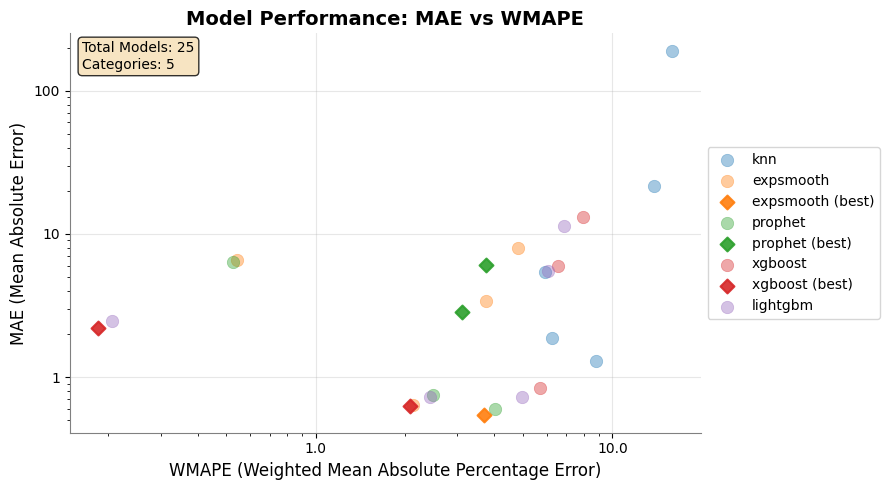

In [40]:
fig, ax = plot_model_performance(model_comparison_df, figsize=(9, 5), logscale=True)

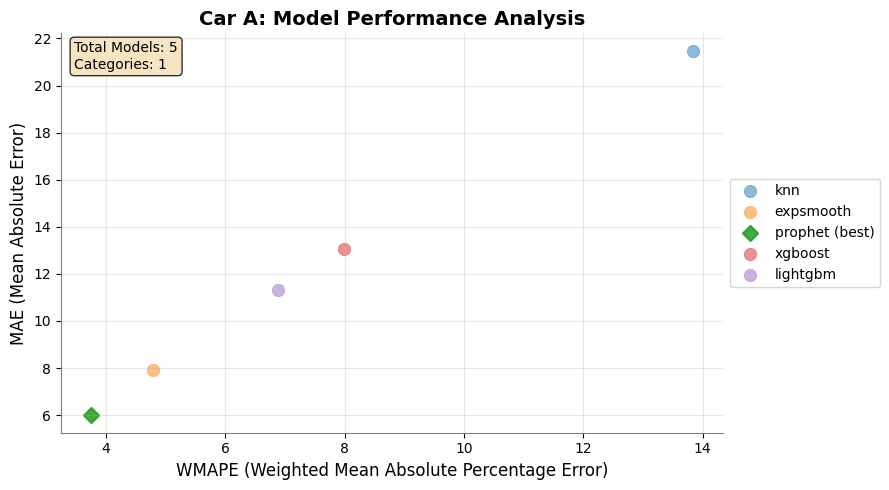

In [41]:
# Single Category
cat = "Car A"

fig, ax = plot_model_performance(
    model_comparison_df[model_comparison_df["category"]==cat], 
    figsize=(9,5),
    alpha_regular=0.5,
    marker_size_best=60,
    title=f"{cat}: Model Performance Analysis"
)

## Individual Model Results
side by side plots with additional parameter details in the caption

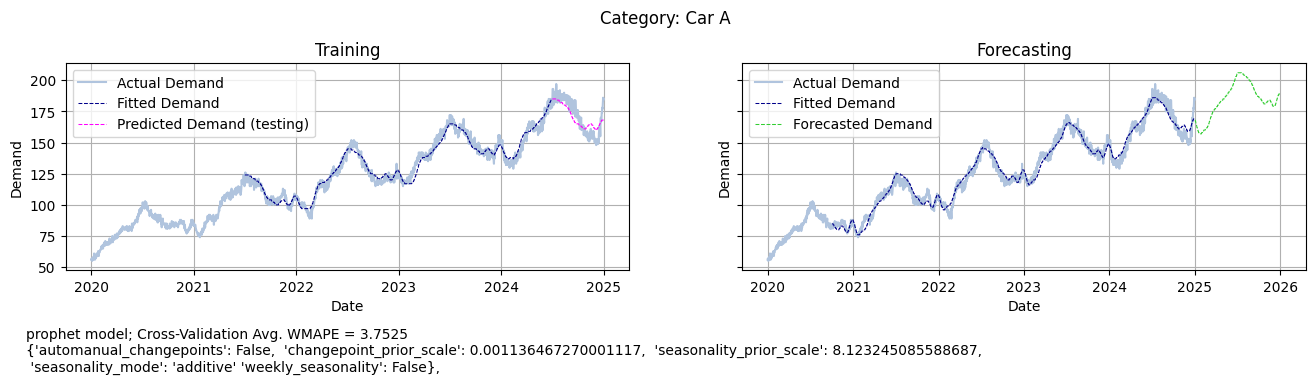

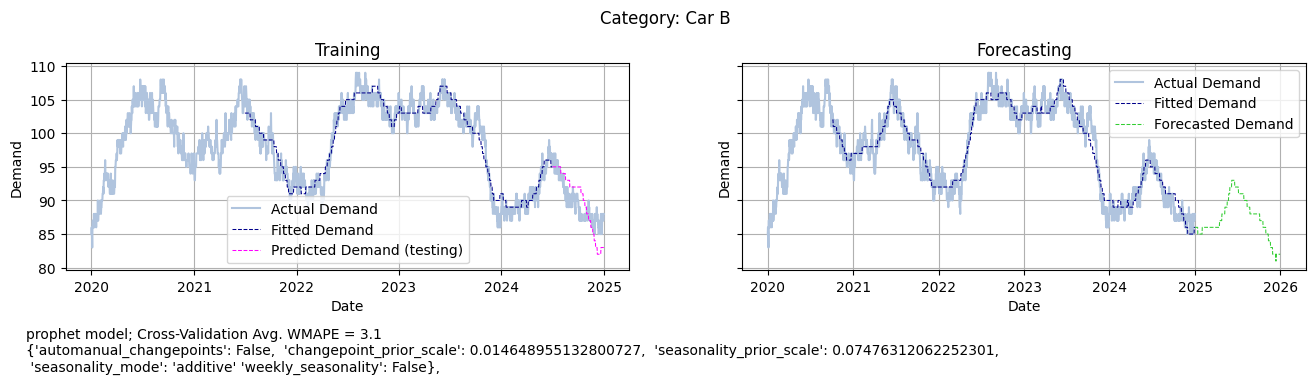

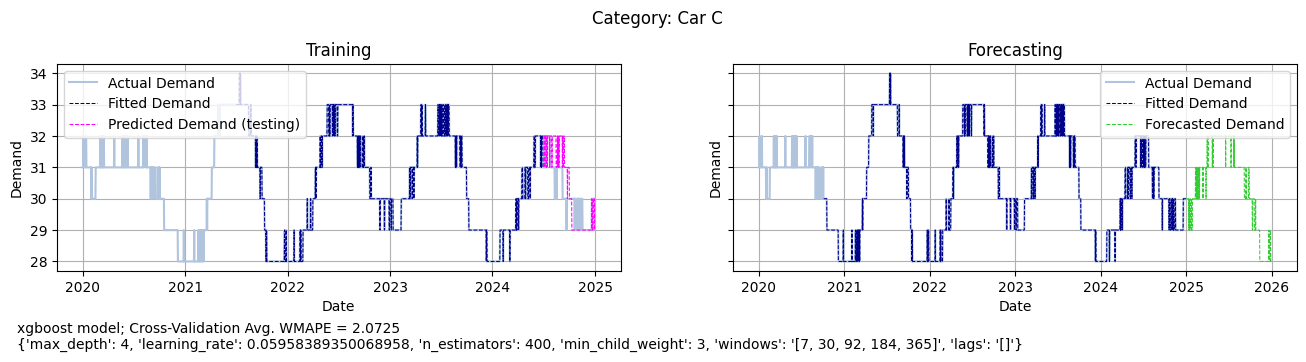

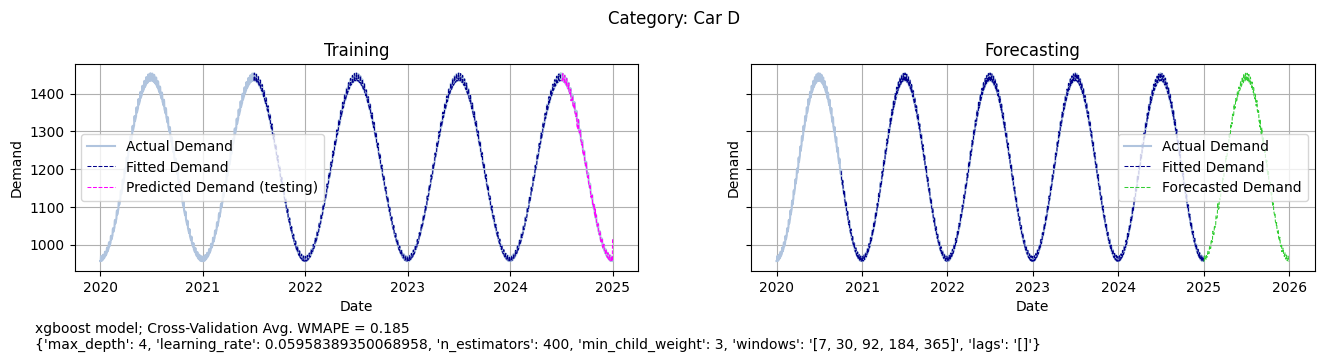

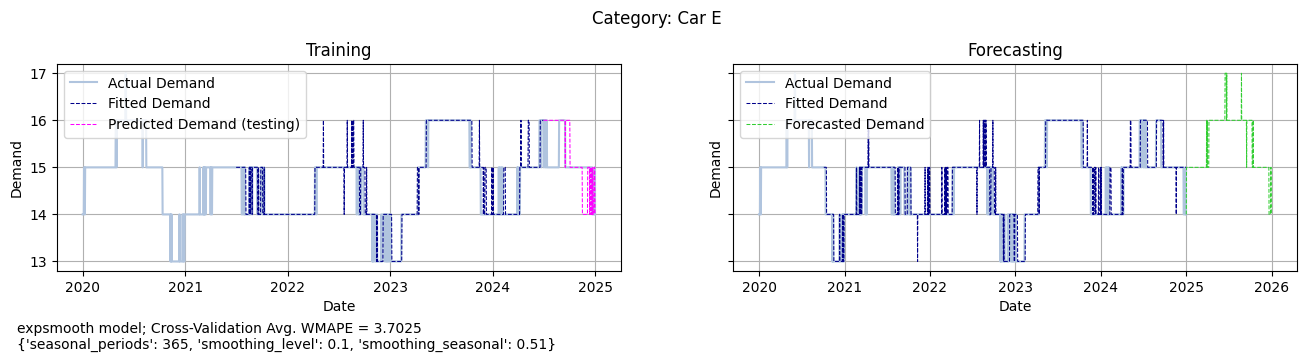

In [42]:
for cat in categories:
    plot_init_model_charts(category = cat,
                           all_date_vals = output_data_df,
                           param_df = param_df)

-----------
# Additional Visualizations

## Single Time Series Plots
Same as above, but pulled out individually.

In [43]:
from tempo_forecasting.utils.plotting_utils import plot_time_series_demand, extract_series_from_date_vals
category_of_interest = "Car A"

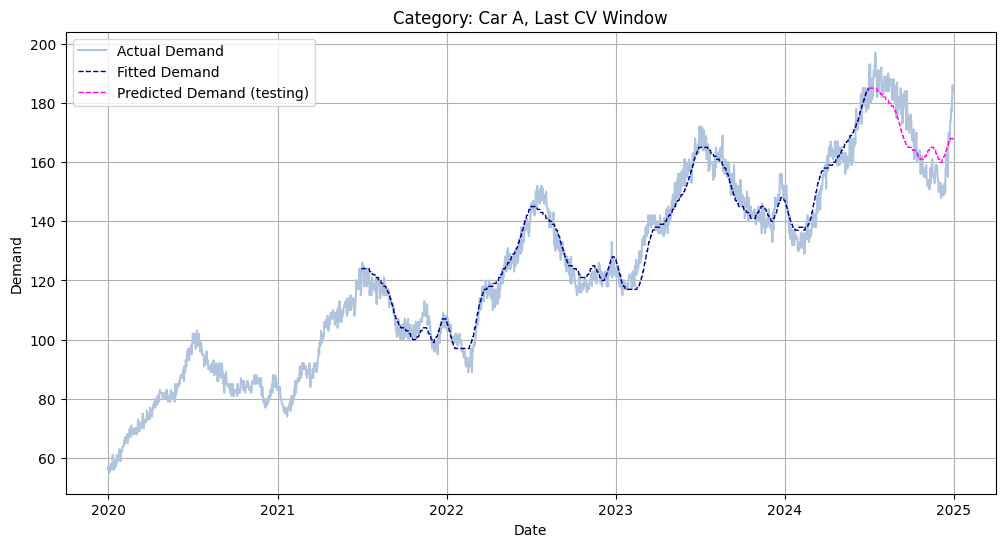

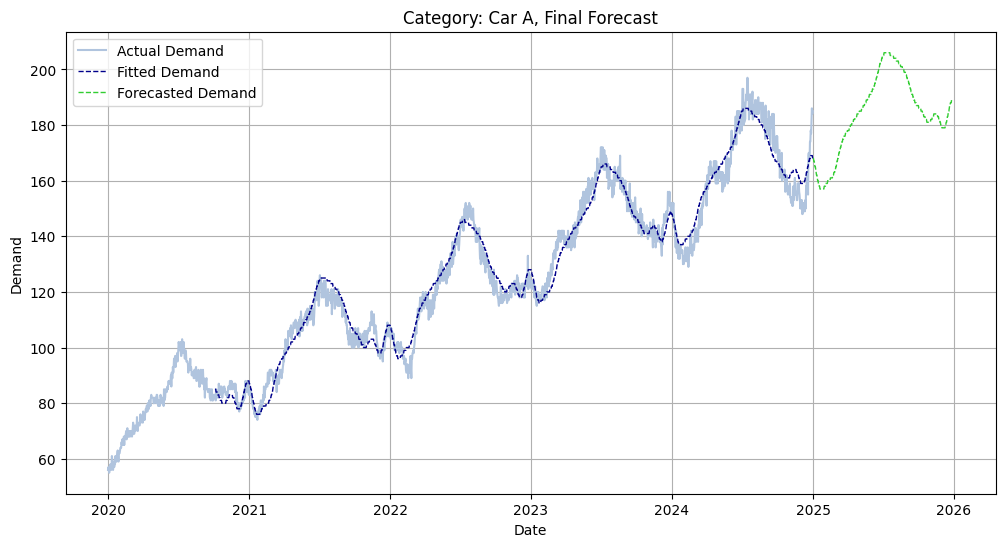

In [44]:
data_series_dict = extract_series_from_date_vals(category_date_vals = output_data_df[(output_data_df["category"] == category_of_interest)])

# Train
plot_time_series_demand(title = f"Category: {category_of_interest}, Last CV Window", 
                        x_label = "Date", 
                        y_label = "Demand",
                        actual_dates = data_series_dict["actuals_full"]["date"], 
                        actual_vals = data_series_dict["actuals_full"]["vals"],
                        fitted_train_dates = data_series_dict["fitted_train"]["date"], 
                        fitted_train_vals = data_series_dict["fitted_train"]["vals"],
                        forecasted_test_dates = data_series_dict["forecasted_test"]["date"], 
                        forecasted_test_vals = data_series_dict["forecasted_test"]["vals"])

# Forecast
plot_time_series_demand(title = f"Category: {category_of_interest}, Final Forecast", 
                        x_label = "Date", 
                        y_label = "Demand",
                        actual_dates = data_series_dict["actuals_full"]["date"], 
                        actual_vals = data_series_dict["actuals_full"]["vals"],
                        fitted_train_dates = data_series_dict["refitted_train"]["date"], 
                        fitted_train_vals = data_series_dict["refitted_train"]["vals"],
                        forecasted_dates = data_series_dict["forecasted"]["date"], 
                        forecasted_vals = data_series_dict["forecasted"]["vals"])

## Deep Dive

It can be helpful to visualize different steps of the modeling process instead of taking Optuna's word that it has selected the best model. In order to do so, we must re-run a slightly modified version of the modified pipeline to capture a higher level of detail. The pipeline passes out time series data only for the best model's final cv window and final re-fit forecast. The code below re-runs modeling and saves time series values for every CV window of every model type, using that model type's best parameters.

In [45]:
from tempo_forecasting.utils.config_utils import get_models
from tempo_forecasting.utils.training_utils import cross_validate
from tempo_forecasting.utils.plotting_utils import core_plotter

category_of_interest = "Car A"

In [46]:
# Extract model details: models, associated classes, and associated parameters
category_cond = (results_df["category"] == category_of_interest)

coi_model_details = results_df[category_cond][["model","best_params"]]\
                            .set_index("model")\
                            .to_dict(orient="index")

model_classes = get_models(how="all")
for model_type in coi_model_details:
    coi_model_details[model_type]["model_class"] = model_classes[model_type]

# Extract modeling data
coi_modeling_data = output_data_df[(output_data_df["category"]==category_of_interest)&
                                   (~output_data_df["true_vals"].isna())][["date","true_vals"]]

In [47]:
desired_metrics = ["wmape","mae"]

# Do CV once (basically, mini train pipeline)
coi_all_results = {}
for model_type in coi_model_details.keys():
    cv_results = cross_validate(data = coi_modeling_data,      
                                date_col = "date", 
                                target_col = "true_vals", 
                                model_class = coi_model_details[model_type]["model_class"],
                                model_param_dict = coi_model_details[model_type]["best_params"], 
                                cv_dates = args["cv_dates"], 
                                metrics = desired_metrics)

    coi_all_results[model_type] = cv_results

# Run Eval Pipeline
eval_pipeline_output = {}
for model_type in coi_all_results.keys():
    data_dict = {
        "data_vals": np.array(coi_modeling_data["true_vals"]),
        "data_dates": np.array(coi_modeling_data["date"]),
        "train_test_split_dates":
            {
                "cv_dates": "date",
                "simple_train_test_dates": args["cv_dates"][-1]
            }
    }

    single_model_result = {
        "cv_metrics": {
            "cv_best_mean_all_metrics": {
                "WMAPE": np.round(np.mean([coi_all_results[model_type][i]["metrics"]["WMAPE"] 
                                for i in range(len(coi_all_results[model_type]))]),2)
            },
            "cv_best_full_all_metrics": {
                "WMAPE": [coi_all_results[model_type][i]["metrics"]["WMAPE"] 
                            for i in range(len(coi_all_results[model_type]))]
            },
        },
        "train_preds": coi_all_results[model_type][-1]["fitted_train_vals"],
        "test_preds": coi_all_results[model_type][-1]["test_pred_vals"],
        "model_params": coi_model_details[model_type]["best_params"]
    }

    eval_pipeline_input = {
        "models": {
            model_type : single_model_result
        },
        "data": data_dict
    }

    final_param_df, vals_df, logger = evaluation_pipeline(category = category_of_interest,
                                                        category_results = eval_pipeline_input,
                                                        args = args,
                                                        target_metric = "WMAPE",
                                                        forecast_horizon = 365,
                                                        logger = "print")
    
    eval_pipeline_output[model_type] = {
        "vals_df" : vals_df,
        "param_df" : final_param_df
    }

Starting evaluation for category: Car A
Available models: ['knn']
Selected best model: knn, with mean cv WMAPE: 13.84
Best model parameters: {'len_q': 120, 'forecast_chunk_size': 60, 'k': 3}
Combining evaluation train and test data
Train WMAPE: 0.0
Test WMAPE: 6.65
Combining train and test data for full retraining
Retraining knn on final training dataset
Successfully retrained model on full dataset
Last date in training data: 2024-12-31
Predicting 365 days ahead
Successfully generated 365 future predictions
Preparing output DataFrames
Evaluation complete for Car A
Summary: knn model with train WMAPE=0.0000, forecast horizon=365 days
Starting evaluation for category: Car A
Available models: ['expsmooth']
Selected best model: expsmooth, with mean cv WMAPE: 4.79
Best model parameters: {'seasonal_periods': 365, 'smoothing_level': 0.8, 'smoothing_seasonal': 0.31000000000000005}
Combining evaluation train and test data
Train WMAPE: 1.68
Test WMAPE: 6.94
Combining train and test data for full

### Demonstration of Cross-Model Performance

Don't judge the poorly performing models below too hard - they would be doing much better if this example notebook gave them more than three Optuna trials.

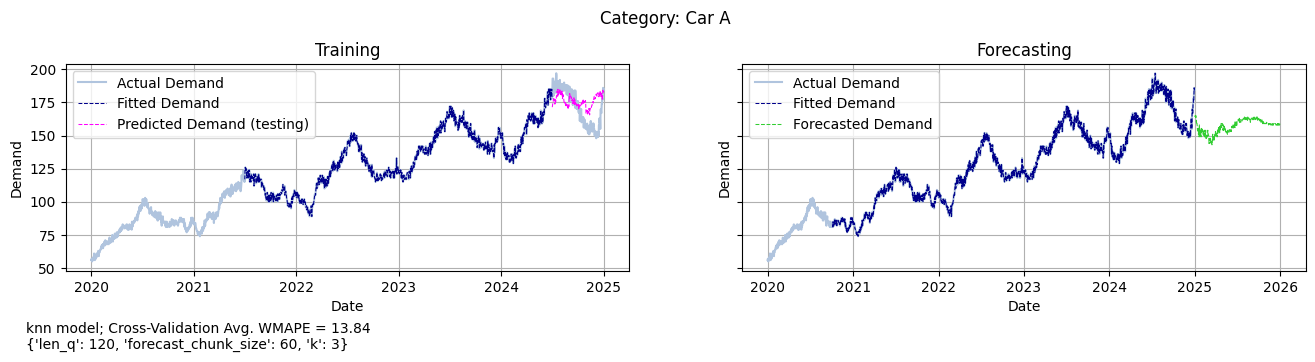

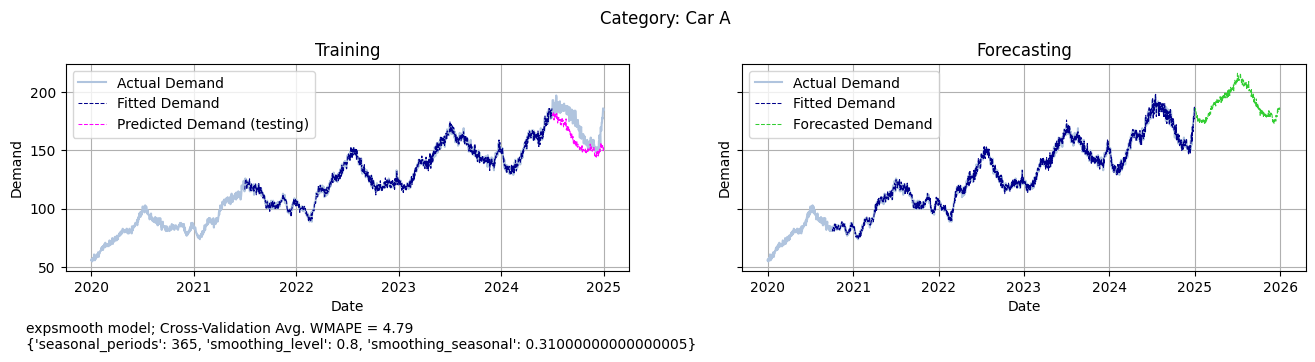

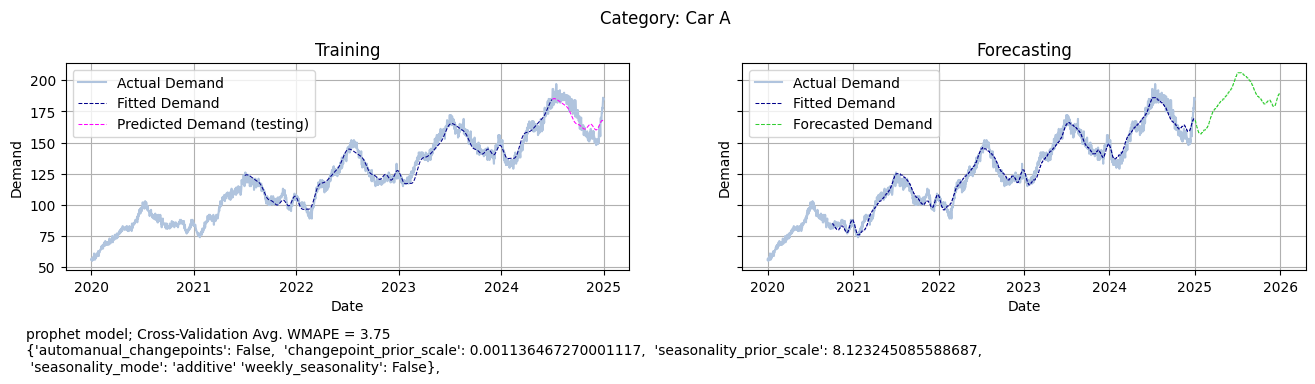

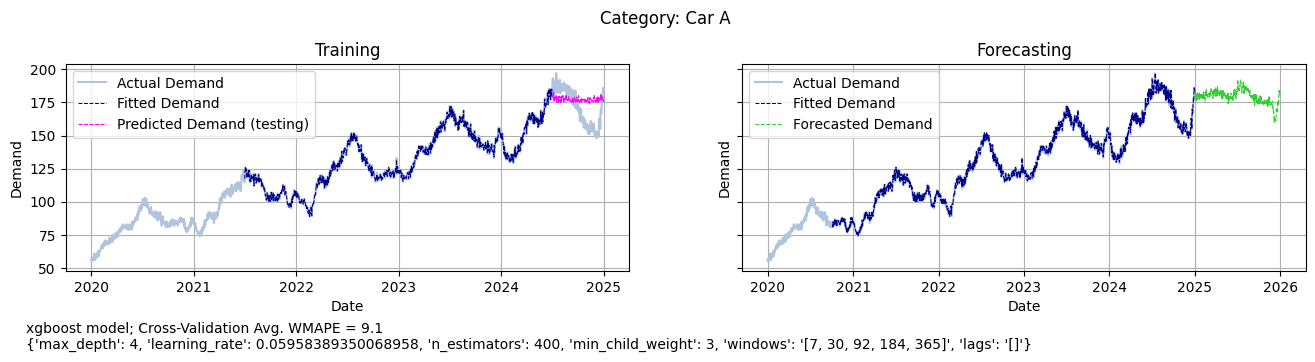

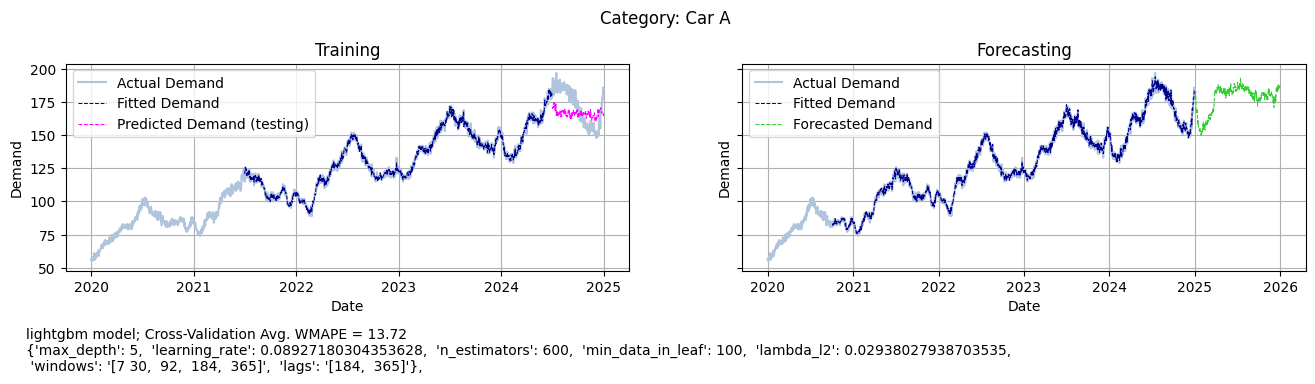

In [48]:
chart_type = "train and pred" 
# or: train only

if chart_type == "train and pred":
    for model_type in eval_pipeline_output:
        plot_init_model_charts(category_of_interest,
                               eval_pipeline_output[model_type]["vals_df"],
                               eval_pipeline_output[model_type]["param_df"])

if chart_type == "train only":
    n_models = len(coi_all_results.keys())
    fig, axes = plt.subplots(n_models,1, sharex=True)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{category_of_interest} - Model Comparison")

    i = 0

    for model_type in coi_all_results.keys():
        cv_min_date, cv_cutoff_date, cv_max_date = coi_all_results[model_type][-1]["dates"]
        fitted_train_date_cond = (coi_modeling_data["date"]>=cv_min_date)&(coi_modeling_data["date"]<=cv_cutoff_date)
        forecasted_test_date_cond = (coi_modeling_data["date"]>cv_cutoff_date)&(coi_modeling_data["date"]<=cv_max_date)

        all_dates = pd.to_datetime(coi_modeling_data["date"])

        mean_model_wmape = np.round(np.mean([coi_all_results[model_type][i]["metrics"]["WMAPE"] 
                                                for i in range(len(coi_all_results[model_type]))]),2)
        model_wmape = coi_all_results[model_type][-1]["metrics"]["WMAPE"]
        core_plotter(title = f"{model_type} model: final cv wmape = {model_wmape}, mean cv wmape = {mean_model_wmape}",
                                ax = axes[i],
                                x_label = "",
                                y_label = "Rental Demand",
                                actual_dates = all_dates,
                                actual_vals = coi_modeling_data["true_vals"],
                                fitted_train_dates = all_dates[fitted_train_date_cond],
                                fitted_train_vals = coi_all_results[model_type][-1]["fitted_train_vals"],
                                forecasted_test_dates = all_dates[forecasted_test_date_cond],
                                forecasted_test_vals = coi_all_results[model_type][-1]["test_pred_vals"])
        i += 1

### Demonstration of Walk Forward CV

In [51]:
models_of_interest = ["prophet"]

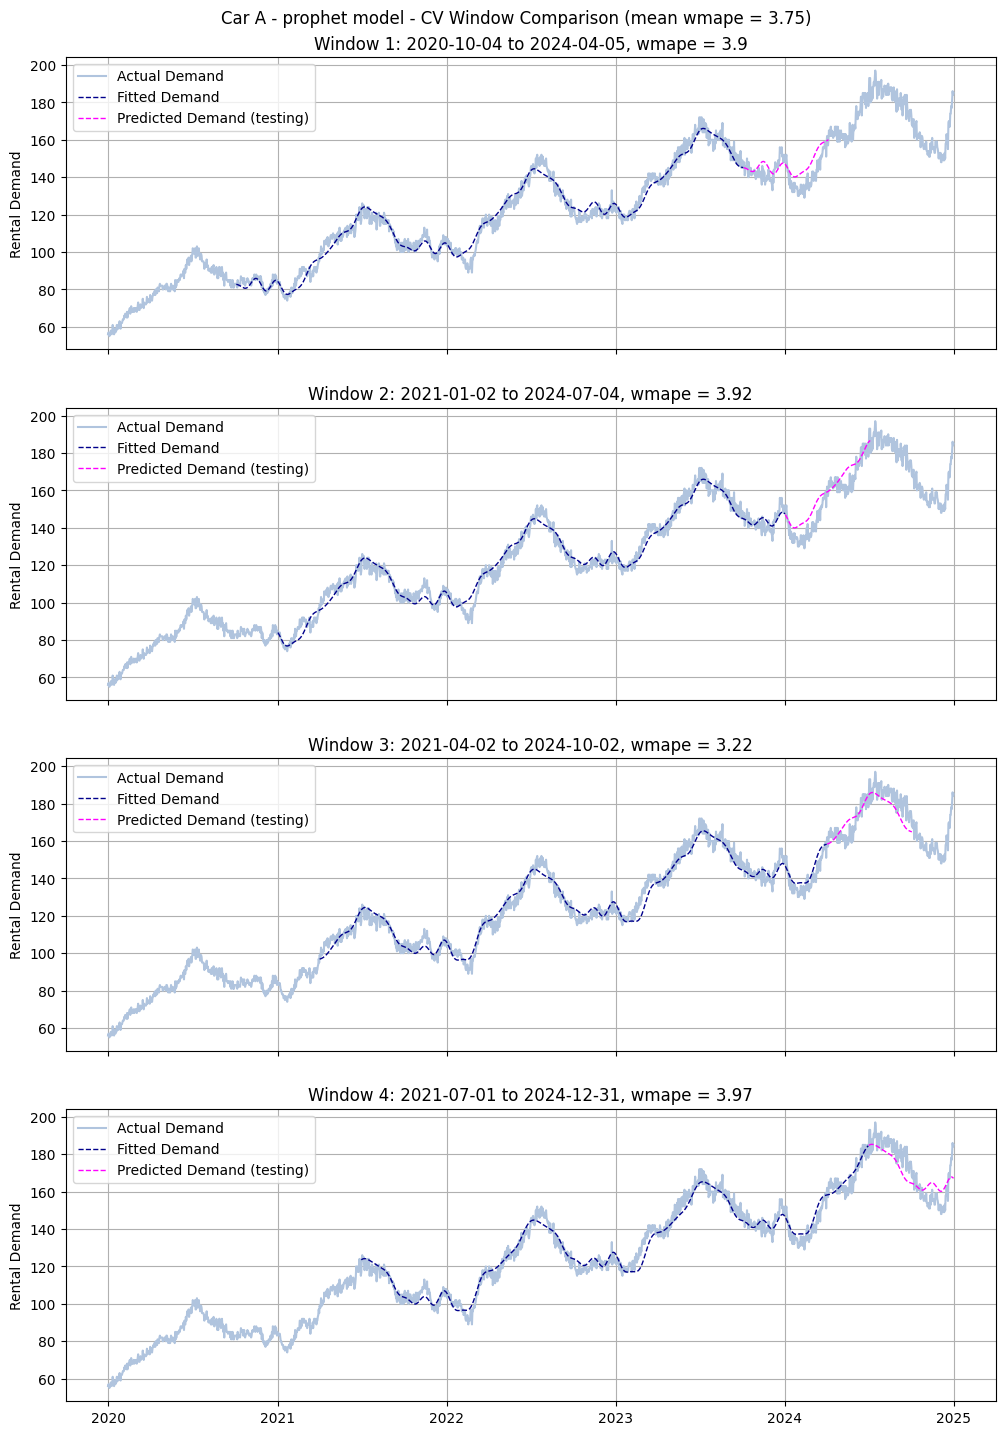

In [52]:
for model_type in models_of_interest:
    n_cv_windows = len(coi_all_results[model_type])
    fig, axes = plt.subplots(n_cv_windows,1, sharex=True)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    fig.subplots_adjust(top=0.95)

    mean_model_wmape = np.round(np.mean([coi_all_results[model_type][i]["metrics"]["WMAPE"] 
                                            for i in range(len(coi_all_results[model_type]))]),2)
    fig.suptitle(f"{category_of_interest} - {model_type} model - CV Window Comparison (mean wmape = {mean_model_wmape})")


    for window_i in range(n_cv_windows):
        cv_min_date, cv_cutoff_date, cv_max_date = coi_all_results[model_type][window_i]["dates"]
        fitted_train_date_cond = (coi_modeling_data["date"]>=cv_min_date)&(coi_modeling_data["date"]<=cv_cutoff_date)
        forecasted_test_date_cond = (coi_modeling_data["date"]>cv_cutoff_date)&(coi_modeling_data["date"]<=cv_max_date)

        all_dates = pd.to_datetime(coi_modeling_data["date"])

        window_wmape = coi_all_results[model_type][window_i]["metrics"]["WMAPE"]
        core_plotter(title = f"Window {window_i+1}: {cv_min_date} to {cv_max_date}, wmape = {window_wmape}",
                     ax = axes[window_i],
                     x_label = "",
                     y_label = "Rental Demand",
                     actual_dates = all_dates,
                     actual_vals = coi_modeling_data["true_vals"],
                     fitted_train_dates = all_dates[fitted_train_date_cond],
                     fitted_train_vals = coi_all_results[model_type][window_i]["fitted_train_vals"],
                     forecasted_test_dates = all_dates[forecasted_test_date_cond],
                     forecasted_test_vals = coi_all_results[model_type][window_i]["test_pred_vals"])